# Hypothesis Testing

## I. Purpose and Background

This project analyzes marathon pace strategy using data scraped from the 2021 Boston Marathon results. For purposes of this project, "pace strategy" can generally be broken down into three types that will be referred to throughout this project:

* "Even pacing" refers to running the second half of the race about as fast as the first half.
* "Positive splits" refers to running the second half of the race slower than the first half.
* "Negative splits" refers to running the second half of the race faster than the first half.

Previous research has generally found differences in marathon pacing for runners of different ability levels, but has been mixed on differences in marathon pacing for runners of different genders. Jared Ward, an American runner who placed 6th in the 2016 Olympic Marathon, also wrote a masters thesis on marathon pace strategy. He analyzed split times for runners in the 2013 St. George Marathon. He found that elite runners tend to run more evenly paced races than non-elite runners, who tend to slow more in the second half of the race. He also found that women tend to run more evenly paced races than men, but elite men and women run more similarly to each other [1].

Alejandro Santos-Lozano et al. studied finishers of the New York Marathon from 2006 to 2011 to examine the impact of ability level and gender on marathon pacing. They found that all runners tend to adopt a positive splits strategy, but that faster runners tend to run more evenly paced races regardless of gender. However, they didn't find significant differences between men and women [2]. Daniel March et al. studied runners in the Last Chance Marathon in Dublin, OH from 2005 to 2007. They found that women and faster runners tend to run more evenly paced races than men and slower runners respectively. However, they did not find any statistically significant interactions between gender and runner ability [3].

Finally, it is also worth noting that four of the last six marathon world records and the two fastest (official) marathons ever run were all actually run with a negative splits strategy, though still fairly close to even pacing [4-5].

This project attempts to answer the following questions for runners age 18-39 who finished the 2021 Boston Marathon in less than 5 hours:

1. Is there any relationship between marathon finish time and pace strategy?
2. Is there any relationship between a runner's gender and their marathon pace strategy?
3. Does the relationship of marathon finish time to pace strategy depend on a runner's gender, or does the relationship of gender to pace strategy depend on a runner's finish time?

## II. Data and Methods

### 1. Data

The data for this project comes from the [2021 Boston Marathon results](https://boston.r.mikatiming.com/2021/?pid=leaderboard&pidp=leaderboard) on the Boston Athletic Association website. The data was scraped using the scrapy library for Python. The code for the scraper is included in the [marathon_scraper](https://github.com/tommcd09/marathon-pace-strategy/tree/main/marathon_scraper) folder of this project. Unfortunately, the BAA does not allow publishing or reposting Boston Marathon results without expressed written consent from the BAA, so the data is not reproduced with this project. However, the data can be obtained and viewed directly from the BAA website.

The raw data contains the following columns:

* <b>place_overall:</b> The runner's overall placing in the race.
* <b>place_gender:</b> The runner's placing within their gender
* <b>place_division:</b> The runner's placing within their age and gender group.
* <b>sex:</b> The runner's gender. Relabeled "gender" during cleaning.
* <b>age_group:</b> An integer representing the runner's age group. These integers were encoded in the URLs of marathon results pages and were used both to crawl through the results and to label the age groups. The numbers map to the following age groups: 1 = 18-39, 2 = 40-44, 9 = 45-49, 3 = 50-54, 10 = 55-59, 4 = 60-64, 11 = 65-69, 8 = 70-74, 12 = 75-79, 13 = 80+.
* <b>name:</b> The runner's first name, last name, and three letter country code.
* <b>bib:</b> The runner's unique bib number. Relabeled "runner_id" during cleaning.
* <b>half_split:</b> The runner's time for the first half of the marathon. Relabeled "first_half" during cleaning.
* <b>finish_net:</b> The runner's finish time measured from the time they crossed the starting line to the time they crossed the finish line. Relabeled "finish" during cleaning.
* <b>finish_gun:</b> The runner's finish time measured from the time of the starting gun to the time they crossed the finish line.

It is possible that this data is not representative of marathon runners generally. The Boston Marathon is a special race among marathons--runners must meet tough qualifying standards or raise large amounts of money for charity to qualify to run. This data also represents runners on a particular course on a particular day with particular weather, all factors which could reduce the randomness of the data. Thus, we should be careful about generalizing the results of this project beyond the 2021 Boston Marathon.

### 2. Methods

The data was cleaned in a separate [cleaning](https://github.com/tommcd09/marathon-pace-strategy/blob/main/cleaning.ipynb) notebook and explored in a separate [exploratory_data_analysis](https://github.com/tommcd09/marathon-pace-strategy/blob/main/exploratory_data_analysis.ipynb) notebook. To analyze the data, this project uses a 2x2 factorial ANOVA to compare the mean difference in first and second half splits as a percentage of overall finish time for different groups of runners based on gender and ability level. Negative split difference percentages represent a negative splits strategy for a particular runner, while a positive split difference represents a positive splits strategy. A split difference of 0 or close to 0 represents even pacing. 

One of the big advantages of using a factorial design is that it allows for testing whether there is an interaction between the effects of gender and ability level [6]. However, a few assumptions [7] must be satisfied in order for ANOVA to be an appropriate method for this project:

1. The distribution of the y variable (i.e., split difference) is normal within each group.
2. Each data point is independent and randomly sampled.
3. There is homogeneity of variance between each group.

And while it isn't a formal assumption, extreme outliers can also influence the results of an ANOVA [8]. 

Exploratory data analysis revealed that while the data is approximately normally distributed for each group, it is not perfectly so. It also revealed that there might be issues with homogeneity of variance between groups. The following analysis will examine each ANOVA assumption in detail before looking at the ANOVA results.

## III. Analysis and Results

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats import power
import matplotlib.pyplot as plt
import seaborn as sns
import anovafuncs as af

pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

boston = pd.read_csv('./data/boston_clean.csv')

### 1. Experiment Setup

Let's bring up size for each group in the data.

In [2]:
boston.groupby('group').size()

group
bq_men         1075
bq_women       1241
no_bq_men       986
no_bq_women    1251
dtype: int64

While it isn't strictly necessary to have experiment groups of the same size, it will make the ANOVA more robust to departures from the assumption of equal variance [6]. Since exploratory analysis revealed there might be unequal variance between groups, this project will randomize the runners into 4 groups of 986. This will be done with a custom experiment_groups function.

In [3]:
boston_exp = af.experiment_groups(boston, 'group', 986, 42)

Let's take a look at some descriptive statistics for each experiment group and visualize the distribution of split difference for each group in a box plot.

In [4]:
boston_exp[['split_diff', 'group']].groupby(['group'])\
.agg([np.mean, np.median, np.std, np.var, min, max])

split_diff                               
                  mean median  std   var    min   max
group                                                
bq_men            3.35   2.80 3.09  9.57  -5.82 14.81
bq_women          3.11   2.71 2.97  8.80  -3.32 16.34
no_bq_men         8.36   7.89 5.48 30.06 -10.32 31.73
no_bq_women       7.06   6.87 4.47 20.01  -6.74 26.76

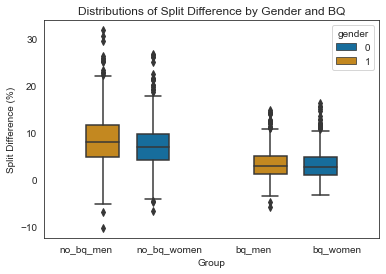

In [5]:
sns.set_style('white')
sns.set_palette('colorblind')

plot_order = boston_exp.groupby('group')['split_diff'].mean()\
.sort_values(ascending=False).index.values
g = sns.boxplot(x='group', y='split_diff', hue='gender', data=boston_exp, order=plot_order)
g.set(title='Distributions of Split Difference by Gender and BQ',
      xlabel='Group', ylabel='Split Difference (%)')
plt.show()

Based on the data above, BQ and gender might have an interactive effect on split strategy. More specifically, the effect of running a Boston Marathon qualifying time on split strategy appears larger for men than it does for women. Thus, this project should look for an interaction effect when running an ANOVA. There are also apparent differences in variance between the four groups.

This project will test 3 null hypotheses:

* There is no difference in group means at either level of the gender variable.
* There is no difference in group means at either level of the bq variable.
* The effect of gender on split difference does not depend on the effect of running a Boston qualifying time.

This project will use a significance ($α$) level of 1% for each of these hypotheses. That is, it will accept a 1% chance of erroneously rejecting each null hypothesis when it is actually true.

Let's fit an ordinary least squares model to the experiment groups using statsmodels. We will have statsmodels regress split_diff on bq, gender, and the interaction of bq and gender. We will use both the residuals and fitted values to test the ANOVA assumptions later, so let's store those in variables for later use.

In [6]:
formula = 'split_diff ~ bq * gender'
fit = smf.ols(formula, data = boston_exp).fit()
resids = fit.resid
fitted_y = fit.fittedvalues

Before actually looking at ANOVA results, we will look at the assumptions that underlie the ANOVA model to see if it is appropriate for the data and if any remedial measures are necessary.

### 2. Experiment Assumptions

#### A. Normality

One of the assumptions of ANOVA is that the distribution of the y variable (i.e., split difference) is normal within each group [7]. One way to assess normality is with formal tests, such as the Shapiro-Wilk test. However, Shapiro-Wilk is more appropriate for smaller sample sizes [9], so it is not a good option here.

Another useful way to assess normality is to look at a quantile-quantile (Q-Q) plot of the residuals for each group. A Q-Q plot plots theoretical quantiles from a distribution against sample quantiles from the data. If both sets of quantiles come from the same distribution, the points should conform to a straight line, represented here in red [10].

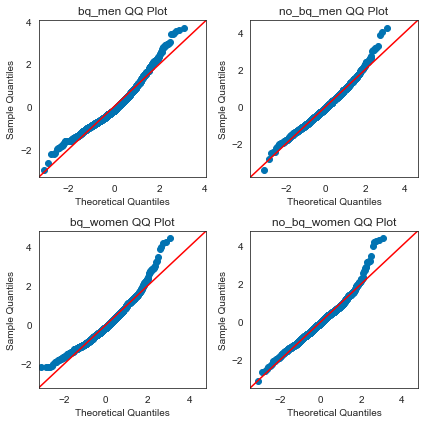

In [7]:
#Group residuals in dictionary by experiment group
resid_dict = {group: resids[resids.index.isin(boston_exp[boston_exp['group'] == group].index)]
              for group in boston_exp['group'].unique()}

af.qq_plots(resid_dict, 2, 2)
plt.show()

These plots don't look perfectly normal, but they are pretty close. We can see some larger departures from normality at the ends of each chart, indicating some kurtosis. A slight U-shape, more noticeable on the BQ plots, indicates some skewness. We can also look at skewness and kurtosis values for each group directly to get a sense of normality.

In [8]:
af.skew_kurtosis(resid_dict)

bq_men skew: 0.7525398812206282
bq_men kurtosis: 3.749818355276907
no_bq_men skew: 0.47329134643678245
no_bq_men kurtosis: 3.7828619545715143
bq_women skew: 0.8153594819815657
bq_women kurtosis: 4.2820009867027835
no_bq_women skew: 0.6099260986417951
no_bq_women kurtosis: 4.549169627217634


A normal distribution would have a skew of 0 and kurtosis of 3, so these values are not huge departures from normality. Moreover, ANOVA is generally robust to departures from the assumption of normality. That is, the actual Type I error rate is still very close to the chosen significance level even when the data is non-normal, though less so with unequal sample sizes [6]. Thus, we will consider the assumption satisfied.

#### B. Independence and random sampling

The second assumption is that each data point is independent and each sample was collected using random sampling [7]. In this project, the first part is easily satisfied. As for the second part, while this project has randomly sampled from runners 18-39 in the Boston Marathon who ran under 5 hours, we noted in the introduction that we could reasonably question whether Boston Marathon runners represent a random sample of marathon runners as a whole. If we were to look at several years of results from the Boston Marathon, or aggregated results of several marathons, that might produce something closer to a random sample of all marathon runners. However, at least with respect to the 2021 Boston Marathon, we will consider this assumption satisfied.

#### C. Homogeneity of Variance

The last assumption is homogeneity of variance between each group [7]. We already saw earlier that the variances of the groups were not the same. This can also be visualized by plotting the fitted values of the OLS model against the residuals.

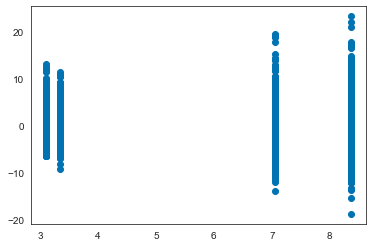

In [9]:
plt.scatter(fitted_y, resids)
plt.show()

There is clearly a megaphone shape to the plot, indicating that variance is increasing as mean split difference is increasing. However, ANOVA is robust to moderate heterogeneity of variance. In their book "Designing Experiments and Analyzing Data: A Model Comparison Perspective", Scott Maxwell, Harold Delaney, and Ken Kelley recommend a rule of thumb for experiments with equal sample size for each group. If the ratio of the largest group variance to the smallest group variance is greater than 4, then we should consider using an alternative method to analyze the data [6]. Let's look again at the variance of split difference each group. 

In [10]:
boston_exp[['split_diff', 'group']].groupby(['group']).agg(np.var)

,split_diff
group,
bq_men,9.57
bq_women,8.80
no_bq_men,30.06
no_bq_women,20.01


We can see that the largest variance is 30.06 and the smallest is 8.80, which means the ratio is less than 4. So, we are probably okay proceeding with the ANOVA. If we were still concerned about homogeneity of variance, one option would be to fit a weighted least squares (WLS) model to the data instead of an ordinary least squares (OLS) model [11]. This would essentially assign weights to the data points when fitting the model. As an extra, an alternative analysis using weighted least squares has been included at the end of this notebook. The results of the weighted least squares analysis are not significantly different than the ordinary least squares analysis, indicating that the ordinary least squares analysis is indeed robust to any heterogeneity of variance here.

#### D. Outliers

While it isn't a formal assumption, we should consider whether any particular data points might be influencing the results of the test. There are many ways that outliers get defined in research [12], but for our purposes we can think of outliers as being guess values that are extremely large or small compared to the rest of the data. There are multiple ways to identify outliers [12-13], but one way that would work well for this experiment is to use the Tukey box plot method. We define an inner fence at 1.5 times the interquartile range on the upper and lower ends of the data and an outer fence at 3 times the interquartile range on the upper and lower ends. Any points between the inner and outer fences are considered "possible outliers" and any points beyond the outer fence are considered "probable outliers". Some of the advantages of this test are that it is relatively robust to outliers (i.e., finding one outlier is independent of other outliers) and that it does not require a normal distribution of data [13]. We will use a function from a wonderful [blog post](https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-1-4ece5098b755) by Alicia Horsch to perform this task [13].

In [11]:
#For each experiment group, run the Tukey function and put the results in a dictionary
outlier_dict = {group: af.tukey(boston_exp[boston_exp['group'] == group], 'split_diff', 'runner_id')
                for group in boston_exp['group'].unique()}

#Print the possible and probable outliers for each group
for key in outlier_dict:
    print(key + f' probable outliers: {outlier_dict[key][0]}')
    print(key + f' possible outliers: {outlier_dict[key][1]}')

bq_men probable outliers: []
bq_men possible outliers: [2044, 795, 565, 377, 918, 657, 726, 962, 1181, 908, 3271, 274, 594, 1380, 2071, 433, 2187, 759, 344, 1370, 848, 2745, 2422, 940]
no_bq_men probable outliers: []
no_bq_men possible outliers: [2149, 1103, 871, 1638, 16897, 4006, 1767, 1069, 18485, 1924, 1599, 1365, 339, 2389, 17134]
bq_women probable outliers: []
bq_women possible outliers: [1290, 6768, 5890, 5828, 4803, 6213, 5589, 7435, 3009, 5009, 4751, 6037, 150, 827, 8033, 4965, 5361, 6952, 6281, 6063]
no_bq_women probable outliers: [8296, 6871]
no_bq_women possible outliers: [9349, 6224, 10385, 7709, 19216, 9079, 9725, 8406, 9119, 4658, 19336, 11135, 9014, 5178, 8413, 8542, 7001, 9724]


The function only identified 2 runners as probable outliers, while it identified many more as possible outliers. 

Once outliers are identified, we could, among other things [12], keep them [12,14], drop them [12,14], recode them with a different value [12,14], transform our data to reduce their impact [8,12,15], or use a different method or model to analyze the data that is more robust to outliers [8,12,15]. As a general rule, we should not drop or alter outliers without a good objective reason, and we should not drop or alter them simply because they do not fit the general trend of our data [16]. In fact, outliers might contain interesting and useful knowledge about the phenomenon being studied [12]. If we could show that any outliers were actually the result of error, or are not a part of the population of interest in our experiment, that would be a good reason to drop or alter them [12,16]. So, let's look more closely at the outliers. First, the probable outliers:

In [12]:
prob_outliers = boston_exp[boston_exp['runner_id'].isin(outlier_dict['no_bq_women'][0])]
prob_outliers

,place_overall,place_gender,place_division,gender,runner_id,first_half,finish,country,last_name,first_name,second_half,split_diff,bq,group
3000,12512,5791,2233,0,8296,1.68,4.56,United States,Decarpentrie,Sarah,2.88,26.42,0,no_bq_women
3227,12257,5641,2189,0,6871,1.64,4.49,United States,Folsom,Ashley,2.84,26.76,0,no_bq_women


These are both women running about 4.5 hour times who ran a significantly slower second half than first half. We don't have enough information to determine if there was a measurement or data entry error, so we must assume the times are all correct. A time of around three hours for the second half split corresponds to an average speed of about 4.37 mph, or about 13:44/mile. It's possible that these runners walked significant portions of the second half, especially if they ran the first half in well under two hours, but we cannot be certain of that. It's entirely plausible that they simply ran the whole race, but did the first half too fast and had to slow down for the second half, which would make them still of interest for this project. Thus, the safest thing to do would be to keep them in the experiment as is.

We can also look at the possible outliers, though the reasoning above very likely holds for them too.

In [13]:
poss_list = outlier_dict['no_bq_women'][1] + outlier_dict['bq_women'][1]\
            + outlier_dict['no_bq_men'][1] + outlier_dict['bq_men'][1]
poss_outliers = boston_exp[boston_exp['runner_id'].isin(poss_list)]
poss_outliers

,place_overall,place_gender,place_division,gender,runner_id,first_half,finish,country,last_name,first_name,second_half,split_diff,bq,group
5,1797,1594,998,1,2044,1.31,3.05,United States,Predmore,Zachary,1.74,14.06,1,bq_men
42,963,878,677,1,795,1.24,2.90,United States,Harden,William,1.66,14.29,1,bq_men
100,1193,1078,784,1,565,1.29,2.95,United States,Benitez,Braulio,1.66,12.47,1,bq_men
107,525,477,407,1,377,1.23,2.77,United States,Conrad,Matthew,1.54,11.24,1,bq_men
140,1126,1016,754,1,918,1.30,2.94,Mexico,Benitez,Luis,1.63,11.25,1,bq_men
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3502,11451,5179,2088,0,5178,1.70,4.31,United States,Shaw,Carolyn,2.61,21.06,0,no_bq_women
3584,11555,5231,2104,0,8413,1.75,4.33,United States,Howe,Katie,2.58,19.10,0,no_bq_women
3619,10678,4701,1972,0,8542,1.56,4.17,United States,Fernandez,Lindsy,2.60,24.94,0,no_bq_women
3687,12137,5577,2174,0,7001,1.75,4.46,United States,Peeters,Sophie,2.70,21.32,0,no_bq_women


Not all rows are displayed for brevity, but these points all have perfectly plausible splits, and there is no way to tell if there was an error or if anyone actually walked. Overall, there isn't a compelling reason to alter or drop the outliers.

Now that we are reasonably sure the assumptions are satisfied and have decided to leave outliers as is, we turn to the ANOVA results.

### 3. ANOVA Results

In [14]:
af.anova_table(fit, 'ANOVA Table of Split Difference on BQ, Gender, and Interaction')

ANOVA Table of Split Difference on BQ, Gender, and Interaction
            sum_sq      df       F  PR(>F)
Intercept 49183.56    1.00 2874.50    0.00
bq         7714.54    1.00  450.87    0.00
gender      834.96    1.00   48.80    0.00
bq:gender   276.67    1.00   16.17    0.00
Residual  67414.65 3940.00     NaN     NaN



The main effect of BQ is statistically significant at the $α$ = 1% level (F(1, 3940) = 450.87, p = 0.00). The main effect of gender is also statistically significant (F(1, 3940) = 48.80, p = 0.00). And importantly, the interaction of BQ and gender is also statistically significant (F(1, 3940) = 16.17, p = 0.00). Since we have a statistically significant interaction, we can reject the null hypothesis that the effect of gender on split difference does not depend on the effect of running a Boston qualifying time. However, we should further run a simple effects analysis to get a better idea of how significant BQ and gender are individually. To do this we will run a series of one-way ANOVAs, first holding gender constant and looking at the significance of BQ, then holding BQ constant and looking at the significance of gender.

In [15]:
#Group data by gender and specify OLS formula
boston_men = boston_exp[boston_exp['gender'] == 1]
boston_women = boston_exp[boston_exp['gender'] == 0]
formula = 'split_diff ~ bq'

##Fit OLS models to gender data
fit_men = smf.ols(formula, data=boston_men).fit()
fit_women = smf.ols(formula, data=boston_women).fit()

#Print ANOVA tables for fitted models
af.anova_table(fit_men,
               'ANOVA Table of Split Difference on BQ for Men, Simple Effects')
af.anova_table(fit_women,
               'ANOVA Table of Split Difference on BQ for Women, Simple Effects')

ANOVA Table of Split Difference on BQ for Men, Simple Effects
            sum_sq      df       F  PR(>F)
Intercept 68978.87    1.00 3481.37    0.00
bq        12400.11    1.00  625.83    0.00
Residual  39033.02 1970.00     NaN     NaN

ANOVA Table of Split Difference on BQ for Women, Simple Effects
            sum_sq      df       F  PR(>F)
Intercept 49183.56    1.00 3413.88    0.00
bq         7714.54    1.00  535.47    0.00
Residual  28381.63 1970.00     NaN     NaN



The effect of running a Boston Marathon qualifying time is statistically significant for both men (F(1, 1970) = 625.83, p = 0.00) and women (F(1, 1970) = 535.47, p = 0.00) at $α$ = 1%. Thus, we can reject the null hypothesis of no difference in group means at either level of the BQ variable for runners of either gender. Now let's look at the simple effect of gender.

In [16]:
#Group data by BQ and specify OLS formula
boston_bq = boston_exp[boston_exp['bq'] == 1]
boston_no_bq = boston_exp[boston_exp['bq'] == 0]
formula = 'split_diff ~ gender'

#Fit OLS models to BQ data
fit_bq = smf.ols(formula, data=boston_bq).fit()
fit_no_bq = smf.ols(formula, data=boston_no_bq).fit()

#Print ANOVA tables for fitted models
af.anova_table(fit_bq,
               'ANOVA Table of Split Difference on Gender for BQ Runners, Simple Effects')
af.anova_table(fit_no_bq,
               'ANOVA Table of Split Difference on Gender for Non-BQ Runners, Simple Effects')

ANOVA Table of Split Difference on Gender for BQ Runners, Simple Effects
            sum_sq      df       F  PR(>F)
Intercept  9517.92    1.00 1036.30    0.00
gender       28.86    1.00    3.14    0.08
Residual  18093.50 1970.00     NaN     NaN

ANOVA Table of Split Difference on Gender for Non-BQ Runners, Simple Effects
            sum_sq      df       F  PR(>F)
Intercept 49183.56    1.00 1964.50    0.00
gender      834.96    1.00   33.35    0.00
Residual  49321.15 1970.00     NaN     NaN



The effect of gender is actually not statistically significant for runners who run a Boston qualifying time (F(1, 1970) = 3.14, p = 0.08), while it is significant for runners who didn't run a Boston qualifying time (F(1, 1970) = 33.35, p = 0.00). Thus, we cannot reject the null hypthesis of no difference in group means at either level of the gender variable, but only for runners who run a Boston qualifying time. For runners who didn't run a Boston qualifying time, we can reject the null hypothesis.

### 4. Effect Size

While the ANOVA tells us which effects are statistically significant, it does not tell us the size of each effect. One common way of measuring effect size is Cohen's d, or the standardized mean difference. Cohen's d is calculated by taking the absolute difference in means between two samples of data and dividing it by the pooled standard deviation of the two samples. The result is a number indicating by how many standard deviations the means of the two samples differ. For example, a Cohen's d of 1 indicates that the means differ by one standard deviation [17].

Let's calculate Cohen's d for the difference between BQ men and no BQ men, BQ women and no BQ women, and No BQ men and no BQ women. Since there is no statistically significant difference between Men BQ and Women BQ, we will skip that.

In [17]:
boston_groups = {group: boston_exp[boston_exp['group'] == group]['split_diff']
     for group in boston_exp['group'].unique()}

print('Effect size of BQ on men: '
      f'{af.cohens_d(boston_groups["no_bq_men"], boston_groups["bq_men"])}')
print('Effect size of BQ on women: '
      f'{af.cohens_d(boston_groups["no_bq_women"], boston_groups["bq_women"])}')
print('Effect size of men on no BQ: '
      f'{af.cohens_d(boston_groups["no_bq_women"], boston_groups["no_bq_men"])}')

Effect size of BQ on men: 1.1272667668872098
Effect size of BQ on women: 1.0427165776442184
Effect size of men on no BQ: 0.26022319969284585


The results here indicate large effect sizes for BQ on both men and women (1.13 and 1.04 standard deviations, respectively). That is, the mean difference in split times as a percentage of total finish time is 1.13 standard deviations smaller for men who ran a Boston qualifying time than for men who didn't run a Boston qualifying time. And the mean split difference is 1.04 standard deviations smaller for women who ran a Boston qualifying time than for women who didn't run a Boston qualifying time. Those are both very large differences. The effect size of gender on runners who didn't run a Boston qualifying time is much smaller at 0.26 standard deviations. That is, the mean split difference for women who didn't run a Boston qualifying time is 0.26 standard deviations less than men who didn't run a Boston qualifying time.

### 5. Power Analysis

Statistical power is the probability of detecting an effect when there is in fact a true effect to detect. That is, it is the probability that a statistical test correctly rejects the null hypothesis [18]. Given an effect size, an alpha level, and a sample size, we can calculate this probability for our experiment. We will use statsmodels to calculate the power for an experiment with 986 observations per group at the 1% significance level with an effect size of 0.26, the smallest effect detected in our experiment.

In [18]:
analysis = power.FTestAnovaPower()
pwresult = analysis.solve_power(effect_size=0.26, power=None, alpha=0.01, nobs=986)
print(f'Statistical power: {pwresult}')

Statistical power: 0.9999999875908312


The power for this experiment is very high, with over a 99.99999% chance that we have correctly rejected the null hypotheses.

### 6. Discussion

These results indicate that running a fast time in the 2021 Boston Marathon was related to running a much more evenly paced race. One possible explanation for this is that faster runners have better coaching and are thinking more about their strategy [1]. Assuming that better coaching leads to better training, then runners who are better coached are likely to both be faster (leading to faster finish times) and more resistant to fatigue (leading to less slowing in the second half of the race). Faster runners also might have run more previous marathons, which might give them a more realistic sense of their own pace and which pacing strategies work better. So, it's possible that experience and coaching, rather than finish time itself, is the true determinant of pacing strategy.

There was a much smaller but still statistically significant effect of gender on runners who did not run a Boston Marathon qualifying time. Women tended to run more evenly paced races, at least among the non-BQ runners. One possible explanation for this is that there is evidence that women have some natural advantages when it comes to distance running. Women have a lower respiratory exchange ratio during endurance exercise compared to similarly trained men, leading to using proportionately more fat and less carbohydrate at a given relative intensity. This could delay the onset of glycogen depletion, which can cause marathon runners to "hit the wall" and slow down late in the race [3]. This might also explain why there isn't a statistically significant difference between BQ men and BQ women. Top runners generally have better running economy, which could delay glycogen depletion and overheating and thus reduce the risk of slowing down [2].

## IV. Conclusion

This project performed a 2x2 factorial ANOVA to compare the effects of gender and ability level on pace strategy, expressed as the difference between the second and first half splits as a percentage of overall finish time, for runners age 18-39 who finished the 2021 Boston Marathon faster than five hours.

The ANOVA revealed that there was a statistically significant interaction between the effects of gender and running a Boston qualifying time (F(1, 3940) = 16.17, p = 0.00).

Simple main effects analysis showed that running a Boston qualifying time had a statistically significant effect on split difference for both men (p = 0.00) and women (p = 0.00). The effect sizes of running a Boston qualifying time on men and women were 1.13 and 1.04 standard deviations, respectively. That is, men and women who ran BQ times ran split differences that were 1.13 and 1.04 standard deviations lower respectively than men and women who didn't run BQ times.

Simple main effects analysis showed that gender did not have a statistically significant effect on split difference for runners who ran a Boston qualifying time (p = 0.08), but did have a statistically significant effect for runners who did not run a Boston qualifying time (p = 0.00). The effect size of being male on runners who did not run a Boston qualifying time was 0.26 standard deviations.

A major limitation of this project is the uniqueness of both the Boston Marathon in general and the 2021 Boston Marathon in particular. A larger amount of data, either from more runnings of the Boston Marathon or from a wider cross-section of marathons, would help to determine whether these results hold up generally across all marathons. Another major limitation of this project is looking only at runner age 18-39. An interesting follow up to this experiment would be to run a similar experiment on a larger selection of data and also examine the effects of age on pace strategy.

## V. EXTRA: Weighted Least Squares

In situations where we might question whether we have enough homogeneity of variance to run an ordinary least squares ANOVA, one alternative option is running a weighted least squares ANOVA. In weighted least squares, we apply weights to the variances of the residuals to balance out differences in variance between groups. Because we know the residuals of the ordinary least squares model, we can compute weights for each group of residuals that are equal to 1/var(resids_i) for i = 1, 2, 3, and 4, where resids_i is the set of residuals for each group in the experiment [11].

First, let's create a dictionary of weights for each group from the dictionary of residuals that we already have

In [19]:
weight_dict = {key: 1/np.var(resid_dict[key]) for key in resid_dict}

Now that we have a dictionary of weights, let's add a "weight" column to the experiment DataFrame and assign the appropriate weight to each data point.

In [20]:
for group in boston_exp['group'].unique():
    boston_exp.loc[boston_exp['group'] == group, 'weight'] = weight_dict[group]

Using the same general formula as in the ordinary least squares example, we can fit a weighted least squares model to the data using the weights we computed and run the ANOVA using that model.

In [21]:
formula = 'split_diff ~ bq * gender'
wls_fit = smf.wls(formula, data=boston_exp, weights=boston_exp['weight']).fit()
wls_resids = wls_fit.resid
wls_fitted_y = wls_fit.fittedvalues
af.anova_table(wls_fit, 'WLS ANOVA Table of Split Difference on BQ, Gender, and Interaction')

WLS ANOVA Table of Split Difference on BQ, Gender, and Interaction
           sum_sq      df       F  PR(>F)
Intercept 2460.43    1.00 2457.93    0.00
bq         536.02    1.00  535.47    0.00
gender      33.38    1.00   33.35    0.00
bq:gender   16.19    1.00   16.17    0.00
Residual  3944.00 3940.00     NaN     NaN



The p-values we got for the weighted least squares ANOVA were the same as with ordinary least squares. To check whether we have applied the right weights, we can compute the standardized residuals for the weighted least squares model and plot them against the fitted values [11]. If we did the weights correctly, we should see that each group has a similar variance.

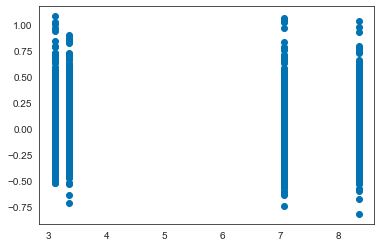

In [22]:
standardized_resids = af.standardized_resids(wls_resids, 3944)

#Multiply each standardized residual by 1/sqrt(weight) for that residual
wls_standardized_resids = [standardized_resids[index] * np.sqrt(x)
                           for index, x in enumerate(boston_exp['weight'])]

#Create a DataFrame matching standardized residuals to fitted values and show a plot
df = pd.DataFrame({'wls_fitted_y':wls_fitted_y, 'wls_standardized_resids':wls_standardized_resids})
plt.scatter(df['wls_fitted_y'], df['wls_standardized_resids'])
plt.show()

The spread of residuals for each group now looks almost the same.

As with ordinary least squares, we should perform a simple effects analysis to see if there are any differences in the main effects of BQ and gender.

In [23]:
#Group data by gender and specify WLS formula
boston_men = boston_exp[boston_exp['gender'] == 1]
boston_women = boston_exp[boston_exp['gender'] == 0]
formula = 'split_diff ~ bq'

##Fit WLS models to gender data
fit_men = smf.wls(formula, data=boston_men, weights=boston_men['weight']).fit()
fit_women = smf.wls(formula, data=boston_women, weights=boston_men['weight']).fit()

#Print ANOVA tables for fitted models
af.anova_table(fit_men, 'WLS ANOVA Table of Split Difference on BQ for Men, Simple Effects')
af.anova_table(fit_women, 'WLS ANOVA Table of Split Difference on BQ for Women, Simple Effects')

WLS ANOVA Table of Split Difference on BQ for Men, Simple Effects
           sum_sq      df       F  PR(>F)
Intercept 2296.88    1.00 2294.55    0.00
bq         626.47    1.00  625.83    0.00
Residual  1972.00 1970.00     NaN     NaN

WLS ANOVA Table of Split Difference on BQ for Women, Simple Effects
           sum_sq      df       F  PR(>F)
Intercept 1637.73    1.00 2063.13    0.00
bq         389.75    1.00  490.99    0.00
Residual  1563.80 1970.00     NaN     NaN



The p-values match what we got with ordinary least squares.

In [24]:
#Group data by BQ and specify WLS formula
boston_bq = boston_exp[boston_exp['bq'] == 1]
boston_no_bq = boston_exp[boston_exp['bq'] == 0]
formula = 'split_diff ~ gender'

#Fit WLS models to BQ data
fit_bq = smf.wls(formula, data=boston_bq, weights=boston_bq['weight']).fit()
fit_no_bq = smf.wls(formula, data=boston_no_bq, weights=boston_bq['weight']).fit()

#Print ANOVA tables for fitted models
af.anova_table(fit_bq,
               'WLS ANOVA Table of Split Difference on Gender for BQ Runners, Simple Effects')
af.anova_table(fit_no_bq,
               'WLS ANOVA Table of Split Difference on Gender for Non-BQ Runners, Simple Effects')

WLS ANOVA Table of Split Difference on Gender for BQ Runners, Simple Effects
           sum_sq      df       F  PR(>F)
Intercept 1082.22    1.00 1081.13    0.00
gender       3.15    1.00    3.14    0.08
Residual  1972.00 1970.00     NaN     NaN

WLS ANOVA Table of Split Difference on Gender for Non-BQ Runners, Simple Effects
           sum_sq      df       F  PR(>F)
Intercept 5592.36    1.00 2063.13    0.00
gender      91.00    1.00   33.57    0.00
Residual  5339.92 1970.00     NaN     NaN



Again, we get the same p-values as with ordinary least squares. Given that weighted least squares gives the same essential results as ordinary least squares, ordinary least squares is sufficient for this project.

# References

1. Reese CS, Ward J. 'Analyzing Split Times For Runners In The 2013 St. George Marathon'. https://www.runblogrun.com/2017/04/17/Jared%20Ward%20Thesis.pdf.
2. Santos-Lozano A, Collado P, Foster C, Lucia A, Garatachea N. (2014) 'Influence of Sex and Level on Marathon Pacing Strategy. Insights from the New York City Race'. International Journal of Sports Medicine. 35. 10.1055/s-0034-1367048. https://www.researchgate.net/publication/260226395_Influence_of_Sex_and_Level_on_Marathon_Pacing_Strategy_Insights_from_the_New_York_City_Race.
3. March DS, Vanderburgh PM, Titlebaum PJ, Hoops ML. (2011) 'Age, Sex, and Finish Time as Determinants of Pacing in the Marathon'. Journal of Strength and Conditioning Research: February 2011 - Volume 25 - Issue 2 - p 386-391. https://journals.lww.com/nsca-jscr/Fulltext/2011/02000/Age,_Sex,_and_Finish_Time_as_Determinants_of.14.aspx.
4. Beverly J. September 30, 2014, 'What World Records Teach About Marathon Pacing'. Runner's World. https://www.runnersworld.com/training/a20819476/what-world-records-teach-about-marathon-pacing/.
5. Kelly M. September 29, 2019, 'A side-by-side comparison of Kipchoge and Bekele’s Berlin Marathons'. Canadian Running. https://runningmagazine.ca/sections/runs-races/a-side-by-side-comparison-of-kipchoge-and-bekeles-berlin-marathons/.
6. Maxwell SE, Delaney HD, Kelley K (2018). Designing Experiments and Analyzing Data: A Model Comparison Perspective, Third Edition. Routledge.
7. Bobbitt Z. December 30, 2018, 'Two-Way ANOVA: Definition, Formula, and Example'. Statology. https://www.statology.org/two-way-anova/.
8. Grace-Martin K. 'Outliers: To Drop or Not to Drop'. The Analysis Factor. https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/.
9. Mishra, P, Pandey, CM, Singh, U, Gupta, A, Sahu, C, Keshri, A. (2019) 'Descriptive statistics and normality tests for statistical data'. Annals of cardiac anaesthesia, 22(1), 67–72. https://doi.org/10.4103/aca.ACA_157_18.
10. Ford C. August 26, 2015, 'Understanding Q-Q Plots'. University of Virginia Library Research Data Services + Sciences. https://data.library.virginia.edu/understanding-q-q-plots/.
11. Pardoe I, Simon L, Young D. 'Nonconstant Variance and Weighted Least Squares'. Penn State Eberly College of Science: STAT 462: Applied Regression Analysis. https://online.stat.psu.edu/stat462/node/186/.
12. Aguinis H, Gottfredson RK, Joo H. 2013 'Best-practice recommendations for defining, identifying, and handling outliers'. Organizational Research Methods, 16(2), 270-301. http://www.hermanaguinis.com/ORMoutliers.pdf.
13. Horsch A. November 22, 2020, 'Detecting And Treating Outliers In Python — Part 1: Hands-On Tutorial On Univariate Outliers'. Towards Data Science. https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-1-4ece5098b755.
14. Horsch A. February 15, 2021, 'Detecting And Treating Outliers In Python — Part 3: Hands-On Tutorial On Treating Outliers — Winsorizing and Imputation'. Towards Data Science. https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-3-dcb54abaf7b0.
15. Forst J. 'Guidelines for Removing and Handling Outliers in Data'. Statistics By Jim. https://statisticsbyjim.com/basics/remove-outliers/.
16. Pardoe I, Simon L, Young D. 'A Strategy for Dealing with Problematic Data Points'. Penn State Eberly College of Science: Stats 501: Regression Methods. https://online.stat.psu.edu/stat501/lesson/11/11.7.
17. Bobbitt Z. August 31, 2021, 'How to Interpret Cohen’s d (With Examples)'. Statology. https://www.statology.org/interpret-cohens-d/.
18. Brownlee J. July 13, 2018, 'A Gentle Introduction to Statistical Power and Power Analysis in Python'. Machine Learning Mastery. https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/.